<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 🍂 Analyse statistique / Recettes / Saisonnalité

In [1]:
import sys
sys.path.append('..')

# Forcer le rechargement de notre module
from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

if '_data_utils' in sys.modules:
    import _data_utils
    importlib.reload(_data_utils)
    if hasattr(_data_utils, 'data_utils_recipes'):
        importlib.reload(_data_utils.data_utils_recipes)

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !
✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [2]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

✅ RAW_RECIPES chargée : 231,637 lignes × 12 colonnes
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • de

## Analyse statistique

### Analyse 1 : Volume de recettes
#### Visualisation

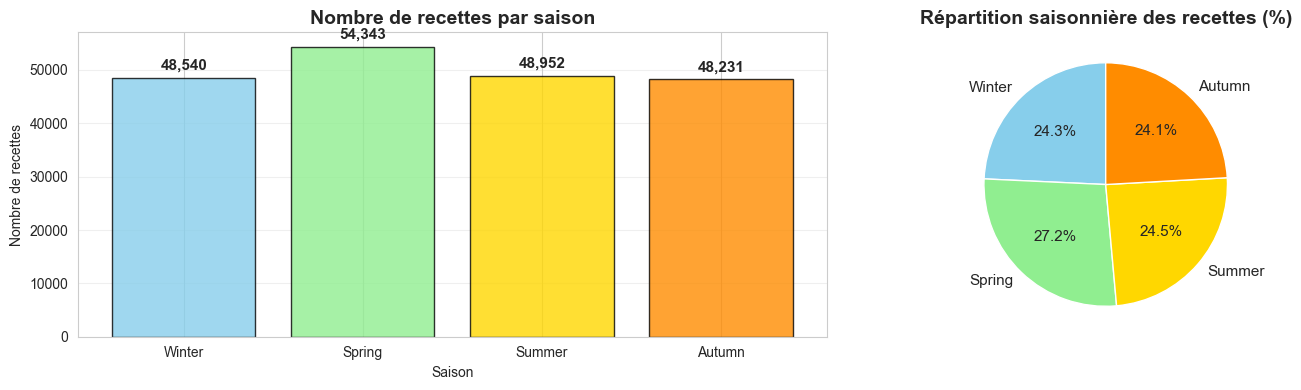

In [3]:
recipes_per_season = (df.group_by("season").agg(pl.len().alias("n_recipes")).sort("season").to_pandas())

# Visualization
season_order = ["Winter", "Spring", "Summer", "Autumn"]
season_colors = {"Winter": "#87CEEB", "Spring": "#90EE90", "Summer": "#FFD700", "Autumn": "#FF8C00"}
recipes_per_season = recipes_per_season.set_index('season').loc[season_order].reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

colors = [season_colors[season] for season in recipes_per_season['season']]
bars = ax1.bar(recipes_per_season['season'], recipes_per_season['n_recipes'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Nombre de recettes par saison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Saison')
ax1.set_ylabel('Nombre de recettes')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, recipes_per_season['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

sizes = recipes_per_season['n_recipes']
labels = recipes_per_season['season']
colors_pie = [season_colors[season] for season in recipes_per_season['season']]
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 11})
ax2.set_title('Répartition saisonnière des recettes (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

In [4]:
observed = recipes_per_season['n_recipes'].values
expected_uniform = [recipes_per_season['n_recipes'].sum() / 4] * 4

chi2_stat, chi2_p = chisquare(observed, expected_uniform)
print(f"Test Chi-2 (uniformité): χ² = {chi2_stat:.4f} (p = {chi2_p:.6f})")
print(f"Répartition uniforme: {'❌ Rejetée' if chi2_p < 0.05 else '✅ Acceptée'}")

mean_recipes = recipes_per_season['n_recipes'].mean()
std_recipes = recipes_per_season['n_recipes'].std()
cv = (std_recipes / mean_recipes) * 100

print(f"\nVariabilité saisonnière:")
print(f"   • Moyenne: {mean_recipes:.0f} recettes/saison")
print(f"   • Écart-type: {std_recipes:.0f} recettes")
print(f"   • Coefficient de variation: {cv:.1f}%")

print(f"\n🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:")
print("-" * 50)

for _, row in recipes_per_season.iterrows():
    season_fr = row['season']
    count = int(row['n_recipes'])
    deviation = count - mean_recipes
    deviation_pct = (deviation / mean_recipes) * 100
    status = "📈" if deviation > 0 else "📉" if deviation < -std_recipes else "➡️"
    print(f"{status} {season_fr:>12}: {count:>7,} ({deviation:+6.0f}, {deviation_pct:+5.1f}%)")


Test Chi-2 (uniformité): χ² = 504.2301 (p = 0.000000)
Répartition uniforme: ❌ Rejetée

Variabilité saisonnière:
   • Moyenne: 50016 recettes/saison
   • Écart-type: 2899 recettes
   • Coefficient de variation: 5.8%

🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:
--------------------------------------------------
➡️       Winter:  48,540 ( -1476,  -3.0%)
📈       Spring:  54,343 ( +4326,  +8.7%)
➡️       Summer:  48,952 ( -1064,  -2.1%)
➡️       Autumn:  48,231 ( -1786,  -3.6%)


> **💡 Interprétation :** 
>  
> Le **test du χ²** montre que la **répartition saisonnière** du nombre de recettes **n’est pas uniforme**, avec des **écarts significatifs** entre les saisons.  
>
> Le **printemps**, nettement au-dessus de la moyenne, indique une **saisonnalité marquée** dans la production, tandis que les autres saisons restent **relativement stables**.  
>
> Cette **surreprésentation printanière** explique le **rejet de l’uniformité** et souligne une **tendance saisonnière modérée** mais **statistiquement significative**.


### Analyse 2: Évolution de la durée moyenne
#### Visualisation

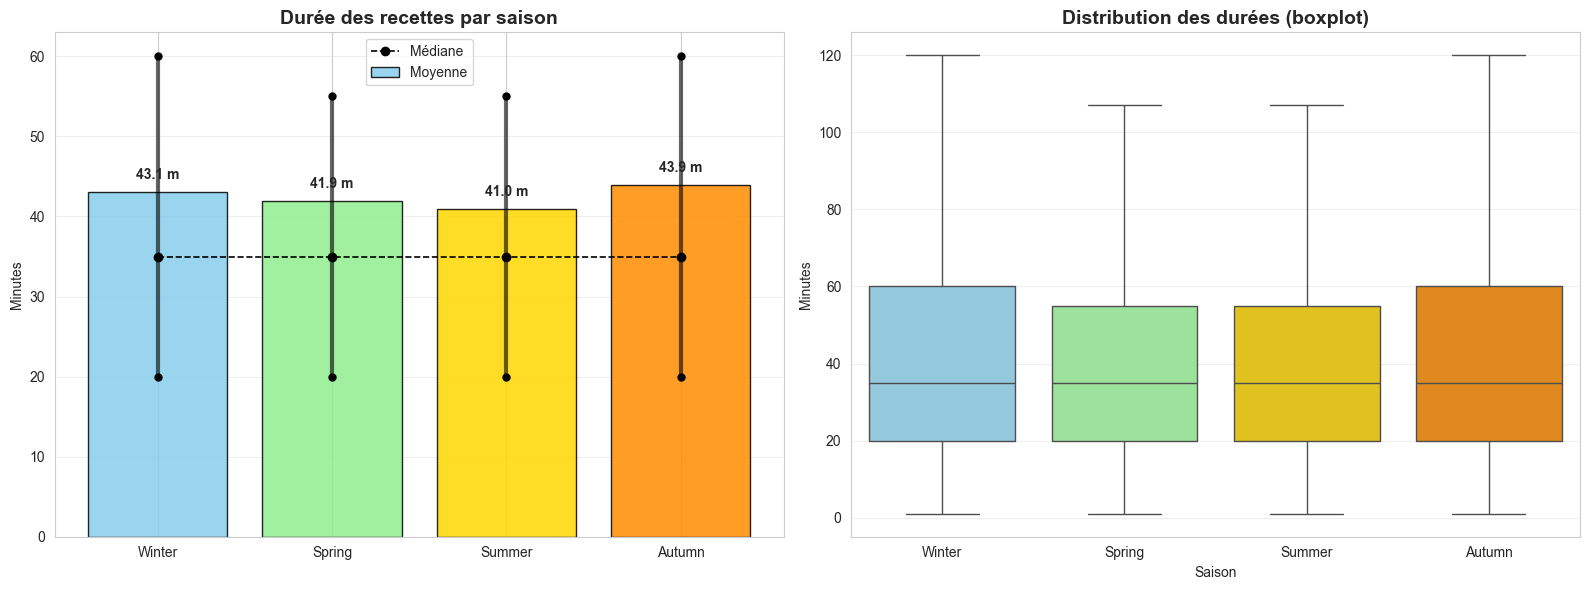

In [5]:
minutes_by_season = (df.group_by("season")
    .agg([
        pl.mean("minutes").alias("mean_minutes"), pl.median("minutes").alias("median_minutes"),
        pl.quantile("minutes",0.25).alias("q25"), pl.quantile("minutes",0.75).alias("q75"), pl.len().alias("n_recipes")
    ]).sort("season").to_pandas().set_index("season").loc[season_order].reset_index())
minutes_by_season["IQR"] = minutes_by_season["q75"] - minutes_by_season["q25"]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
bar_colors=[season_colors[s] for s in minutes_by_season.season]
ax1.bar(minutes_by_season.season, minutes_by_season.mean_minutes, color=bar_colors, alpha=.85, edgecolor='black', lw=1,label='Moyenne')
ax1.plot(minutes_by_season.season, minutes_by_season.median_minutes, 'o--', color='black', lw=1.2, ms=6,label='Médiane')
for s,m,med,q25,q75,_n,_iqr in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','n_recipes','IQR']].itertuples(index=False):
    ax1.vlines(s,q25,q75,color='black',lw=3,alpha=.6); ax1.scatter([s],[q25],color='black',s=25); ax1.scatter([s],[q75],color='black',s=25)
    ax1.text(s,m*1.03,f"{m:.1f} m",ha='center',va='bottom',fontsize=10,fontweight='bold')
ax1.set_title("Durée des recettes par saison",fontsize=14,fontweight='bold'); ax1.set_ylabel("Minutes"); ax1.grid(axis='y',alpha=.3); ax1.legend()

sns.boxplot(data=df.to_pandas(), x='season', y='minutes', order=season_order,
            palette=[season_colors[s] for s in season_order], ax=ax2, showfliers=False)
ax2.set_title("Distribution des durées (boxplot)",fontsize=14,fontweight='bold'); ax2.set_xlabel("Saison"); ax2.set_ylabel("Minutes"); ax2.grid(axis='y',alpha=.3)

plt.tight_layout(); 
plt.show()

#### Tests statistique et interprétation

In [6]:
# Résumé + Test Kruskal 
print("\nRésumé statistique par saison (minutes):\n" + "-"*55)
for s,m,med,q25,q75,iqr,n in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','IQR','n_recipes']].itertuples(index=False):
    print(f"{s:<8} | Moy:{m:6.1f} | Med:{med:6.1f} | Q25:{q25:6.1f} | Q75:{q75:6.1f} | IQR:{iqr:6.1f} | n={n:,}")
    
kw_stat, kw_p = kruskal(*[df.to_pandas().query('season==@s')['minutes'].values for s in season_order])
print(f"\nKruskal-Wallis: H={kw_stat:.3f}, p={kw_p:.6f}")
print(f"Différences significatives" if kw_p<0.05 else "Pas de différence nette")


Résumé statistique par saison (minutes):
-------------------------------------------------------
Winter   | Moy:  43.1 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,540
Spring   | Moy:  41.9 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=54,343
Summer   | Moy:  41.0 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=48,952
Autumn   | Moy:  43.9 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,231

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives


> **💡 Interprétation :**  
> 
> Le **test de Kruskal-Wallis** (H = 346.93, p < 0.001) confirme des **différences significatives** de durée entre les saisons.  
> 
> Les recettes sont **plus longues en automne (43.9 min)** et en **hiver (43.1 min)**, tandis qu’elles sont **plus courtes en été (41.0 min)**.  
> 
> Cette tendance indique que les **recettes postées en périodes froides** demandent en moyenne **plus de temps de préparation**, alors que **les recettes estivales** sont **plus rapides**, probablement associées à des plats **plus simples ou légers**.  


### Analyse 3: Évolution de la complexité
#### Visualisation

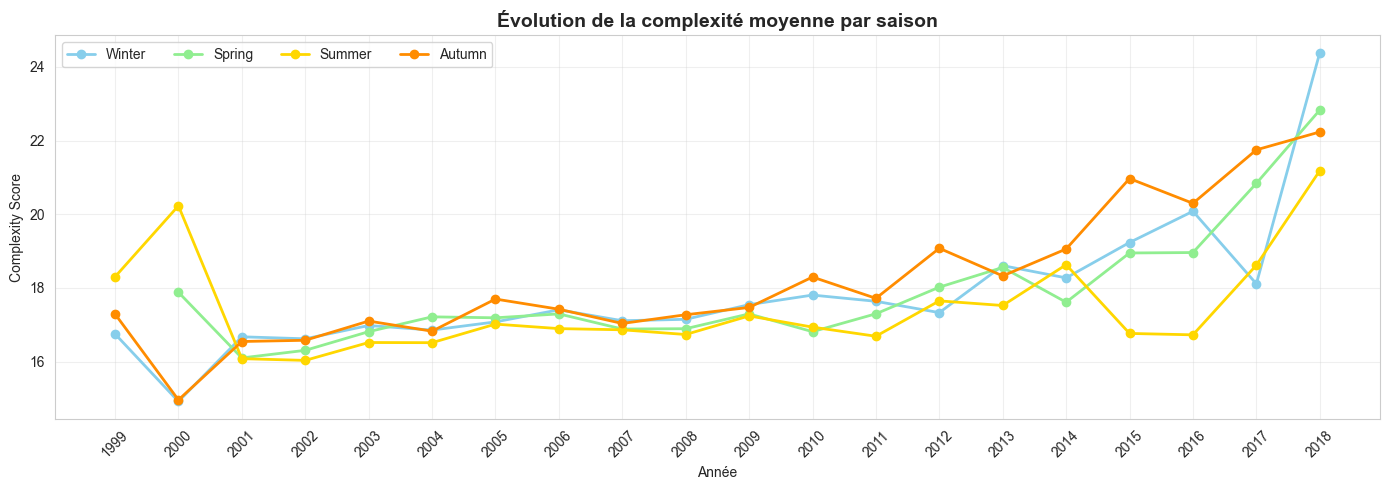

In [ ]:
# Data: score = log1p(minutes) + n_steps + 0.5 * n_ingredients
season_order = ["Winter", "Spring", "Summer", "Autumn"]

comp_season_year = (df.group_by(["year", "season"])\
    .agg([pl.mean("complexity_score").alias("mean_complexity"),
           pl.median("complexity_score").alias("median_complexity"),
           pl.std("complexity_score").alias("std_complexity"),
           pl.len().alias("n")])\
    .sort(["year", "season"]).to_pandas())

pivot_mc = comp_season_year.pivot(index="year", columns="season", values="mean_complexity")[season_order]

fig, ax = plt.subplots(figsize=(14,5))
for s in season_order:
    ax.plot(pivot_mc.index, pivot_mc[s], marker='o', linewidth=2, label=s, color=season_colors[s])
ax.set_title("Évolution de la complexité moyenne par saison", fontsize=14, fontweight='bold')
ax.set_xlabel("Année"); ax.set_ylabel("Complexity Score")
years_int = [int(y) for y in pivot_mc.index]
ax.set_xticks(pivot_mc.index)
ax.set_xticklabels(years_int, rotation=45)

ax.grid(alpha=0.3); ax.legend(ncol=4)
plt.tight_layout(); plt.show()

#### Tests statistique et interprétation

In [10]:
# ANOVA factorielle: complexité ~ saison * année
import statsmodels.formula.api as smf
import statsmodels.api as sm

# S'assurer que year est numérique
if df['year'].dtype.kind not in ('i','u','f'):
    df['year'] = df['year'].astype(int)

model_a = smf.ols('complexity_score ~ C(season) * year', data=df).fit()
anova_tbl = sm.stats.anova_lm(model_a, typ=2)

# Eta squared
anova_tbl['eta_sq'] = anova_tbl['sum_sq'] / anova_tbl['sum_sq'].sum()
print(anova_tbl[['sum_sq','df','F','PR(>F)','eta_sq']])

p_season = anova_tbl.loc['C(season)','PR(>F)']
p_inter = anova_tbl.loc['C(season):year','PR(>F)']
eta_season = anova_tbl.loc['C(season)','eta_sq']
eta_inter = anova_tbl.loc['C(season):year','eta_sq']

print("\nRésumé:")
print(f"Effet saison: p={p_season:.3g} | eta²={eta_season:.3f} -> {'Significatif ✅' if p_season<0.05 else 'Non significatif ❌'}")
print(f"Interaction saison*année: p={p_inter:.3g} | eta²={eta_inter:.3f} -> {'Pentes différentes ✅' if p_inter<0.05 else 'Pentes similaires ❌'}")

# Si interaction non signif: modèle réduit pour pente globale
a = None
if p_inter >= 0.05:
    model_reduced = smf.ols('complexity_score ~ C(season) + year', data=df).fit()
    slope_global = model_reduced.params.get('year', float('nan'))
    print(f"Pente globale (modèle sans interaction): {slope_global:.4f} pts/an")
else:
    print("Interaction présente: interpréter les pentes séparées.")

AttributeError: 'Int32' object has no attribute 'kind'

> **💡 Interprétation ANOVA (complexité)**
> 
> • L'effet principal "saison" teste si la complexité moyenne diffère entre les saisons (toutes années ajustées).  
> • Le terme d'interaction "saison:année" teste si la pente temporelle varie selon la saison (évolutions non parallèles).  
> • η² (eta squared) indique la part de variance expliquée par chaque terme.
> 
> Guide rapide:  
> • p < 0.05 sur "C(season)" → différences de niveaux entre saisons.  
> • p < 0.05 sur "C(season):year" → dynamique différente (certaines saisons montent/baissent plus).  
> • Si interaction non significative, on interprète la pente globale (modèle réduit).  
> • Si interaction significative, on examine les pentes séparées par saison (cellule précédente des tendances ou extraire model_a.params).  
> 
> Pour aller plus loin: post-hoc pairwise (Tukey) sur les saisons; bootstrap des pentes; modèle mixte si hétérogénéité par année.  